In [1]:
import numpy as np
import treeQuadrature as tq

In [2]:
class SimpleGaussian:
    '''
    Likelihood: N(0, 1/(10*sqrt(2)))
    Prior: U(-1, 1)
    '''
    def __init__(self, D):
        self.D = D
        self.d = tq.exampleDistributions.MultivariateNormal(D=D, mean=[0.0]*D, cov=1/200)
        self.low = -1.0
        self.high = 1.0
        self.p = tq.exampleDistributions.Uniform(D=D, low=self.low, high=self.high)
        
        # Calculate truth
        self.answer = 1/(2.0**D)
        
    def pdf(self, X):
        # Combined pdf ie d(x)*p(x)
        return self.d.pdf(X) * self.p.pdf(X)

$$ \int_{-1}^{1}d(x)p(x) dx $$

$$ 1/(2^D) \cdot \int_{-1}^{1}d(x) dx $$

In [12]:
from queue import SimpleQueue

# Define the Integrator we gonna be testing today
class SimpleIntegrator:
    '''
    A simple integrator has the following pattern:
        - Draw <N> samples
        - Keep performing <split> method on containers...
        - ...until each container has less than <P> samples
        - Then perform  <integral> on each container and sum.
    '''
    
    def __init__(self, N, P):
        self.N = N
        self.P = P
        
    def __call__(self, problem):        
        # Draw samples
        X = problem.d.rvs(self.N)
        self._X = X
        y = problem.pdf(X)
        
        # Construct root container
        D = problem.D
        root = tq.Container(X, y, mins=[problem.low]*D, maxs=[problem.high]*D)
        
        # Contstruct tree using a FIFO queue
        finished_containers = []
        q = SimpleQueue()
        q.put(root)

        while not q.empty():

            c = q.get()

            if c.N <= self.P:
                finished_containers.append(c)
            else:
                children = tq.splits.kdSplit(c)
                for child in children:
                    q.put(child)

        # Integrate containers
        contributions = [tq.containerIntegration.randomIntegral(cont, problem.pdf, n=40) for cont in finished_containers]
        G = np.sum(contributions)
        
        return G, finished_containers, contributions

In [307]:
N = 100_000
P = 10

problem = SimpleGaussian(9)
integ = SimpleIntegrator(N, P)
G, fcs, cs1 = integ(problem)

In [308]:
import matplotlib.pyplot as plt
from matplotlib import cm

# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot()
# ax.set_xlim([-0.3,0.3])
# ax.set_ylim([-0.3,0.3])
# cmap = cm.get_cmap('YlOrRd', 256)

cs = tq.utils.scale(cs1)

print(f'pcntError: {100 * (G - problem.answer) / problem.answer}')

# for container, contribution in zip(fcs, cs):
#     tq.visualisation.plotContainer(ax, container, plot_samples=False, fill=True, ec='black', facecolor=cmap(contribution), alpha=0.4)

pcntError: -73.09745324253377


In [309]:
def remove_small(nremove, cs, fcs):
    a, b = zip(*sorted(zip(cs, fcs)))
    I = np.zeros(nremove+1)
    I[0] = np.sum(a)
    arunning = np.sum(a)
    total = 100_000
    nrunning = 100_000
    for i in range(nremove):
        atemp = a[i]
        arunning -= atemp
        nrunning -= b[i].N
        I[i + 1] = total / nrunning * arunning
    return I

In [310]:
problem.answer

0.001953125

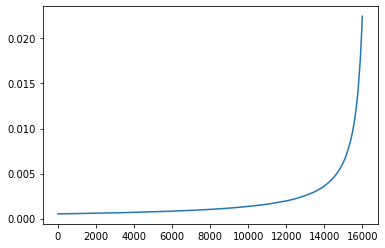

In [311]:
plt.plot(remove_small(16000, cs1, fcs))
plt.show()

In [585]:
def remove_big_container_vols(nremove, cs, fcs):
    vols = [x.volume for x in fcs]
    vols, a, b = zip(*sorted(zip(vols, cs, fcs), reverse=True))
    I = np.zeros(nremove+1)
    I[0] = np.sum(a)
    arunning = np.sum(a)
    total = 100_000
    nrunning = 100_000
    for i in range(nremove):
        atemp = a[i]
        arunning -= atemp
        nrunning -= b[i].N
        I[i + 1] = total / nrunning * arunning
    return I, vols

In [831]:
N = 100_000
P = 10

problem = SimpleGaussian(10)
integ = SimpleIntegrator(N, P)
G, fcs, cs1 = integ(problem)
I, vols = remove_big_container_vols(len(cs1)-100, cs1, fcs)

-1.2646762877034035


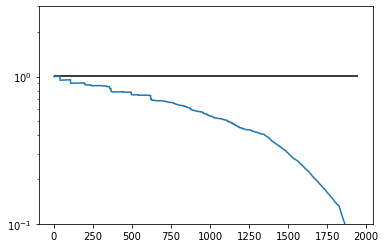

In [958]:
print(100 * (G - problem.answer) / problem.answer)
plt.plot(I/I[0])
plt.hlines(problem.answer/I[0], xmin=0, xmax=len(I))
plt.yscale('log')
plt.ylim(0.1, 3)
plt.show()

-48.85589736920788


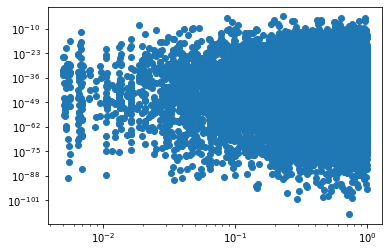

In [835]:
print(100 * (G - problem.answer) / problem.answer)
plt.scatter((sum(vols)-np.cumsum(vols[1:(len(cs1)-100+2)]))/sum(vols), cs1[1:(len(cs1)-100+2)])
# plt.hlines(problem.answer, xmin=0, xmax=len(I))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [836]:
(np.mean(I)-problem.answer)/problem.answer*100

-53.802133406492004

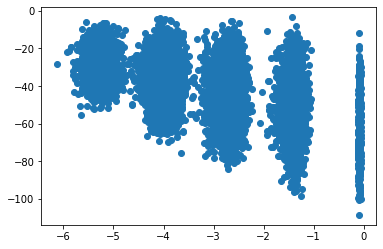

In [837]:
vols = [x.volume for x in fcs]
plt.scatter(np.log10(vols), np.log10(cs1))
plt.show()

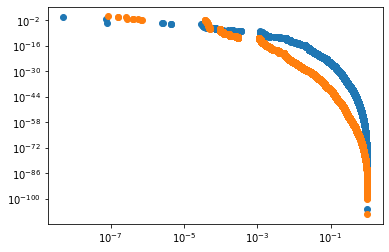

In [838]:
a, vols, b = zip(*sorted(zip(cs1, vols, fcs), reverse=True))
fns = np.array(a)/np.array(vols)
fns, a, vols, b = zip(*sorted(zip(fns, cs1, vols, fcs), reverse=True))
tot_vols = sum(vols)
vols_cumulant = np.cumsum(vols) / tot_vols
plt.scatter(vols_cumulant1, fns1)
plt.scatter(vols_cumulant, fns)
plt.yscale('log')
plt.xscale('log')
plt.show()

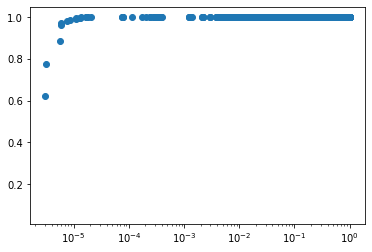

In [839]:
a, vols, b = zip(*sorted(zip(cs1, vols, fcs), reverse=True))
vols_cumulant = np.cumsum(vols) / tot_vols
a_cumulant = np.cumsum(a) / np.sum(a)
plt.scatter(vols_cumulant, a_cumulant)
plt.xscale('log')
plt.ylim(0.01, 1.05)
plt.show()

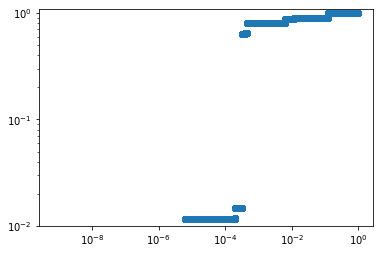

In [840]:
vols, a, b = zip(*sorted(zip(vols, cs1, fcs)))
vols_cumulant = np.cumsum(vols) / tot_vols
a_cumulant = np.cumsum(a) / np.sum(a)
plt.scatter(vols_cumulant, a_cumulant)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.01, 1.1)
plt.show()

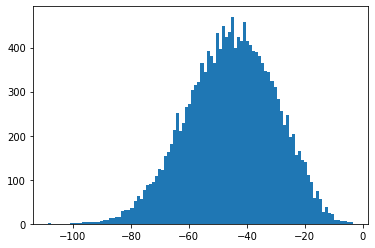

In [841]:
plt.hist(np.log10(a), 100)
plt.show()

In [363]:
def error(D, total_N=100_000, P=10):
    
    def remove_big_container_vols(nremove, cs, fcs):
        vols = [x.volume for x in fcs]
        vols, a, b = zip(*sorted(zip(vols, cs, fcs), reverse=True))
        I = np.zeros(nremove+1)
        I[0] = np.sum(a)
        arunning = np.sum(a)
        total = total_N
        nrunning = total_N
        for i in range(nremove):
            atemp = a[i]
            arunning -= atemp
            nrunning -= b[i].N
            I[i + 1] = total / nrunning * arunning
        return I

    problem = SimpleGaussian(D)
    integ = SimpleIntegrator(total_N, P)
    G, fcs, cs1 = integ(problem)
    I = remove_big_container_vols(len(cs1)-100, cs1, fcs)
    return (G-problem.answer)/problem.answer*100, (np.mean(I)-problem.answer)/problem.answer*100

In [364]:
nreplicates = 50
D=9
raw_error = np.zeros(nreplicates)
corrected_error=np.zeros(nreplicates)
for i in range(nreplicates):
    a, b = error(D)
    raw_error[i] = a
    corrected_error[i] = b

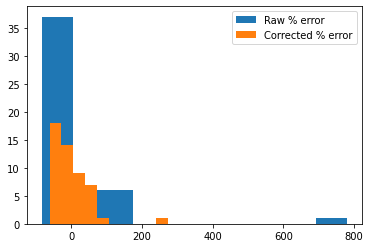

In [365]:
plt.hist(raw_error)
plt.hist(corrected_error)
plt.legend(["Raw % error", "Corrected % error"])
plt.show()

In [335]:
np.std(corrected_error)

52.83083487774913

In [341]:
cs1.pop

[1.6557943788685557e-82,
 1.5916330594846939e-47,
 1.8569402874853143e-60,
 7.501052881019179e-35,
 9.252181764073467e-48,
 2.055473102804939e-53,
 1.6384152958662606e-48,
 1.2871713825441556e-11,
 7.180466044386502e-49,
 1.48322443061946e-53,
 7.768328743692688e-37,
 7.321811097941964e-32,
 2.2474176520686723e-43,
 4.258165241365453e-24,
 2.5544663268972715e-54,
 7.399579758042864e-31,
 1.2827470210529901e-57,
 1.3046752355167338e-36,
 3.6531748718521444e-36,
 4.862829553749334e-37,
 4.899128394911891e-30,
 5.27561849207057e-44,
 5.990332398609674e-28,
 1.5341794151001646e-17,
 2.2341742630664808e-24,
 8.197548118609529e-30,
 1.651967611593273e-27,
 1.595422718563173e-21,
 6.436558933142749e-34,
 1.9294999823148525e-14,
 1.99534761243525e-14,
 3.41225980277869e-17,
 6.672515403767076e-59,
 1.9563992810119343e-45,
 4.749805849162398e-63,
 5.641426223448841e-23,
 3.063620711091048e-48,
 1.5877453003796188e-32,
 1.165056776362253e-37,
 1.59421634309421e-33,
 4.0950500367676056e-42,
 1.65

In [366]:
def error_random(D, total_N=100_000, P=10):
    
    def remove_random_container(nremove, cs, fcs):
        vols = [x.volume for x in fcs]
        vols, a, b = zip(*sorted(zip(vols, cs, fcs), reverse=True))
        I = np.zeros(nremove+1)
        I[0] = np.sum(a)
        arunning = np.sum(a)
        total = total_N
        nrunning = total_N
        for i in range(nremove):
            aindex = np.random.randint(0, len(vols))
            atemp = a[aindex]
            arunning -= atemp
            nrunning -= b[aindex].N
            I[i + 1] = total / nrunning * arunning
        return I

    problem = SimpleGaussian(D)
    integ = SimpleIntegrator(total_N, P)
    G, fcs, cs1 = integ(problem)
    I = remove_random_container(len(cs1)-100, cs1, fcs)
    return (G-problem.answer)/problem.answer*100, (np.mean(I)-problem.answer)/problem.answer*100

In [367]:
nreplicates = 50
D=9
raw_error1 = np.zeros(nreplicates)
corrected_error1=np.zeros(nreplicates)
for i in range(nreplicates):
    a, b = error_random(D)
    raw_error1[i] = a
    corrected_error1[i] = b

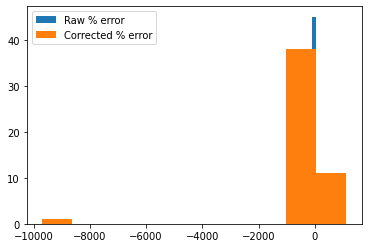

In [371]:
plt.hist(raw_error1)
plt.hist(corrected_error1)
plt.legend(["Raw % error", "Corrected % error"])
plt.show()

In [375]:
def error_sse(D, total_N=100_000, P=10):
    
    def remove_sse(nremove, cs, fcs):
        vols = [np.std(x.y) for x in fcs]
        vols, a, b = zip(*sorted(zip(vols, cs, fcs), reverse=True))
        I = np.zeros(nremove+1)
        I[0] = np.sum(a)
        arunning = np.sum(a)
        total = total_N
        nrunning = total_N
        for i in range(nremove):
            aindex = i
            atemp = a[aindex]
            arunning -= atemp
            nrunning -= b[aindex].N
            I[i + 1] = total / nrunning * arunning
        return I

    problem = SimpleGaussian(D)
    integ = SimpleIntegrator(total_N, P)
    G, fcs, cs1 = integ(problem)
    I = remove_sse(len(cs1)-100, cs1, fcs)
    return (G-problem.answer)/problem.answer*100, (np.mean(I)-problem.answer)/problem.answer*100

In [376]:
nreplicates = 50
D=9
raw_error2 = np.zeros(nreplicates)
corrected_error2=np.zeros(nreplicates)
for i in range(nreplicates):
    a, b = error_sse(D)
    raw_error2[i] = a
    corrected_error2[i] = b

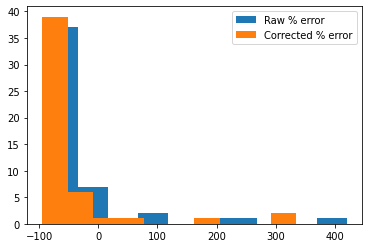

In [377]:
plt.hist(raw_error2)
plt.hist(corrected_error2)
plt.legend(["Raw % error", "Corrected % error"])
plt.show()

In [380]:
np.std(corrected_error2)/np.std(raw_error2)

0.972018794675463

In [381]:
np.std(corrected_error1)/np.std(raw_error1)

7.563622874785084

In [382]:
np.std(corrected_error)/np.std(raw_error)

0.43448736524203524

In [383]:
np.mean(corrected_error)/np.mean(raw_error)

0.5109427632885636

# Measuring effect of peeling using largest container volume

In [384]:
def error_iterations(D, nreplicates):
    raw_error = np.zeros(nreplicates)
    corrected_error=np.zeros(nreplicates)
    for i in range(nreplicates):
        a, b = error(D)
        raw_error[i] = a
        corrected_error[i] = b
    return raw_error, corrected_error

In [385]:
error_iterations(3, 2)

(array([-0.07294802, -0.15834396]), array([-15.78649076, -16.04900648]))

# Sampling from posterior defined by containers

In [949]:
N = 20_000
P = 10

problem = SimpleGaussian(5)
integ = SimpleIntegrator(N, P)
G, fcs, cs1 = integ(problem)
I, vols = remove_big_container_vols(len(cs1)-100, cs1, fcs)
prob = cs1 / np.sum(cs1)
sample_conts = np.random.choice(fcs, 10000, p=prob)
samples = [x.rvs(1) for x in sample_conts]
samples = np.vstack(samples)
smaller = integ._X[1:10000]

In [950]:
print(100 * (G - problem.answer) / problem.answer)

-1.2646762877034035


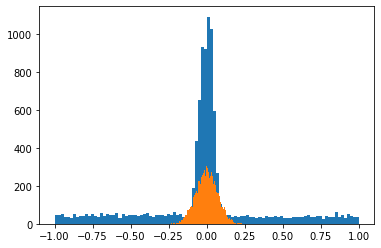

In [951]:
plt.hist(samples[:, 1],100)
plt.hist(smaller[:, 1],100)
plt.show()

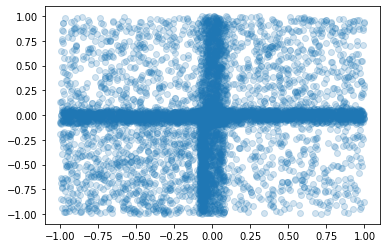

In [952]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2)
plt.show()

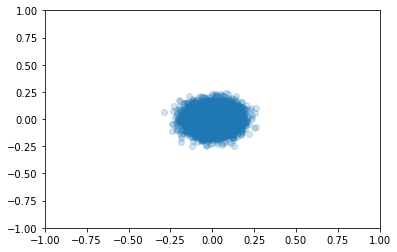

In [954]:
plt.scatter(smaller[:, 0], smaller[:, 1], alpha=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [955]:
np.std(smaller[:, 0])

0.07137452114868034

In [956]:
np.std(samples[:, 0])

0.39763782409541326

In [957]:
np.sqrt(1/200)

0.07071067811865475